In [1]:
import momepy as mm
import numpy as np
import numba
import geopandas as gpd
import pandas as pd
import shapely
from sklearn.preprocessing import StandardScaler
from collections import namedtuple
from core.cluster_validation import get_linkage_matrix
from libpysal.graph import read_parquet, Graph
from core.generate_context import spatially_weighted_partial_lag
from core.generate_clusters import preprocess_clustering_data
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from scipy.cluster.hierarchy import fcluster
from core.utils import used_keys

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [2]:
model_params = '_post_processing_v1'

In [3]:
regions_datadir = "/data/uscuni-ulce/"
morphotopes_dir = '/data/uscuni-ulce/processed_data/morphotopes/'

# model_params = '_75_0_None_None_False'


clip = None
to_drop = [
        'stcSAl','stbOri','stcOri','stbCeA',
        'ldkAre', 'ldkPer', 'lskCCo', 'lskERI','lskCWA', 'ltkOri', 'ltkWNB', 'likWBB', 'likWCe',
          'licBAD', 'misBAD',
    'ssbCCM','ssbCCD'    
]


linkage = 'complete'
metric = 'euclidean'

morphotope_stat_columns = ['percentile_25', 'percentile_75', 'mean', 'std']

In [4]:
def preprocess_data(data, scalar, drop_columns=morphotope_stat_columns):
    component_data = data.drop(columns=drop_columns, level=1)
    component_data = component_data.drop(columns=to_drop, level=0)
    component_data.columns =  component_data.columns.get_level_values(0)
    
    component_data = component_data[component_data.index.str[-2:] != '-1']
    
    vals = scalar.fit_transform(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    component_data = component_data.drop(component_data.columns[component_data.std() == 0], axis=1)
    
    # component_data = component_data[component_data.index >= 0]
    vals = np.nan_to_num(component_data)
    component_data = pd.DataFrame(vals, columns=component_data.columns, index=component_data.index)
    return component_data

def read_region_morphotope_data(region_id, scalar, read_extra=False):
    print('processing' , region_id)
    data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
    
    data.index = str(region_id) + '_' + data.index
    data = data.iloc[:, :-1]
    component_data = preprocess_data(data, scalar)


    if read_extra:
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        vals = scalar.fit_transform(extra_chars)
        extra_chars = pd.DataFrame(vals, columns=extra_chars.columns, index=extra_chars.index).fillna(0)
        extra_chars = extra_chars.drop(component_data.columns[component_data.std() == 0], axis=1)
        extra_chars = extra_chars[['limLPS']]
        extra_chars['limLPS2'] = extra_chars['limLPS']

        merged_data = pd.merge(component_data, extra_chars, how='inner', left_index=True, right_index=True)
        pd.testing.assert_index_equal(merged_data.index, component_data.index)
        component_data = merged_data
    
    return component_data

def get_morphotope_linkage(region_data):
    
    clusterer = AgglomerativeClustering(linkage=linkage,
                                        metric=metric,
                                        compute_full_tree=True,
                                        compute_distances=True)
    model = clusterer.fit(region_data)
    linkage_matrix = get_linkage_matrix(model)
    return linkage_matrix


def get_all_clusters(cutoff):
    
    all_clusters = []
    
    for region_id, _ in region_hulls.iterrows():
        data = read_region_morphotope_data(region_id, scalar=StandardScaler())
        region_index = data.index
        linkage_matrix = np.load(f'/data/uscuni-ulce/processed_data/morphotope_linkage/{linkage}_{metric}_{region_id}.npy')
        clusters = fcluster(linkage_matrix, t=cutoff, criterion='distance')
        clusters = pd.Series(clusters, region_index).astype(str)
        clusters = str(region_id) + '_' +clusters
        all_clusters.append(clusters)
    
    all_clusters = pd.concat(all_clusters)
    
    return all_clusters


def read_morphotopes_data(model_params):
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        region_morphotope_data = pd.read_parquet(f'{morphotopes_dir}data_morphotopes_{region_id}{model_params}.pq')
        region_morphotope_data.index = str(region_id) + '_' + region_morphotope_data.index.str[:]
        data.append(region_morphotope_data)
    
    data = pd.concat(data)
    return data

def read_morphotopes_chars():
    
    data = []
    for region_id, _ in region_hulls.iterrows():
        extra_chars = pd.read_parquet(f'{morphotopes_dir}morph_chars_{region_id}.pq')
        data.append(extra_chars)
    
    data = pd.concat(data)
    return data 
    

def morphotopes_to_etcs(region_id, etcs=True, model_params='_100_0_None_None_False'):


    if etcs:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/tessellations/tessellation_{region_id}.parquet')

    else:
        etcs = gpd.read_parquet(f'/data/uscuni-ulce/processed_data/buildings/buildings_{region_id}.parquet')
        
    etcs['label'] = -1
    
    morphotopes = pd.read_parquet(f'/data/uscuni-ulce/processed_data/morphotopes/tessellation_labels_morphotopes_{region_id}{model_params}.pq')
    morphotopes.loc[:, 'morphotope_label'] =  morphotopes.values[:, 0]

    morph_dict = pd.Series(np.arange(np.unique(morphotopes.values).shape[0]),
                       np.unique(morphotopes.values))
    etcs.loc[morphotopes.index, 'label'] = morphotopes.map(lambda x: morph_dict.loc[x]).values
    etcs['morph'] = str(region_id) + '_' + '-1'
    etcs.loc[morphotopes.index, 'morph'] = str(region_id) + '_' + morphotopes.values
    return etcs

In [5]:

regions_datadir = "/data/uscuni-ulce/"
region_hulls = gpd.read_parquet(
        regions_datadir + "regions/" + "cadastre_regions_hull.parquet"
)

### Direct morphotope hierarchy

In [6]:
%%time
# read morphotopes data
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data[~morphotopes_data.index.str.endswith('-1')]
morphotopes_data = morphotopes_data.iloc[:, :-1]

## drop unwanted columns
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns = component_data.columns.get_level_values(0)



CPU times: user 22.9 s, sys: 8.07 s, total: 31 s
Wall time: 16.6 s


In [7]:
# add morphotope variables
morph_chars_data = read_morphotopes_chars()
morph_chars_data = morph_chars_data[['limLPS', 'limAre', 'limPer']]
merged_data = pd.merge(component_data, morph_chars_data, how='inner', left_index=True, right_index=True)
pd.testing.assert_index_equal(merged_data.index, component_data.index)
component_data = merged_data

In [8]:

grouped_data = component_data

In [9]:
## Drop massive outliers
grouped_data = grouped_data.drop(grouped_data[(grouped_data['limAre'] > 5e5) | (grouped_data['limPer'] > 2e5) | (grouped_data['ldbPWL'] > 5_000) | (grouped_data.sdbAre < 20)].index)

In [10]:
# drop columns
grouped_data = grouped_data.drop(['ssbCor', 'mtdDeg', 'limPer',  'mtbSWR'], axis=1)

In [11]:
from sklearn.preprocessing import StandardScaler
scalar = StandardScaler()
vals = scalar.fit_transform(grouped_data)
vals = np.nan_to_num(vals, 0)
regional_ward_morphotopes_data = pd.DataFrame(vals, index=grouped_data.index, columns=grouped_data.columns)

### Full linkage with graph

In [12]:
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import AgglomerativeClustering
from core.cluster_validation import get_linkage_matrix
from sklearn.neighbors._base import _kneighbors_from_graph

In [13]:
n_neighbors = 10

In [14]:
%%time

# generate knn graph
graph = kneighbors_graph(regional_ward_morphotopes_data.values, n_neighbors=n_neighbors, n_jobs=-1, include_self=True, mode='distance')
dists, nns = _kneighbors_from_graph(graph, n_neighbors, return_distance=True)

CPU times: user 18min 44s, sys: 13.9 ms, total: 18min 44s
Wall time: 2min 5s


In [15]:
emgraph = graph
embedding = regional_ward_morphotopes_data

In [16]:
%%time

linkage='ward'
metric='euclidean'

clusterer = AgglomerativeClustering(linkage=linkage,
                                    metric=metric,
                                    connectivity=emgraph,
                                    compute_full_tree=True,
                                    compute_distances=True)
clusterer.fit(embedding)

CPU times: user 1min 57s, sys: 899 ms, total: 1min 58s
Wall time: 1min 58s


AgglomerativeClustering(compute_distances=True, compute_full_tree=True,
                        connectivity=<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 5192590 stored elements and shape (519259, 519259)>)

In [17]:
linkage_matrix = get_linkage_matrix(clusterer)

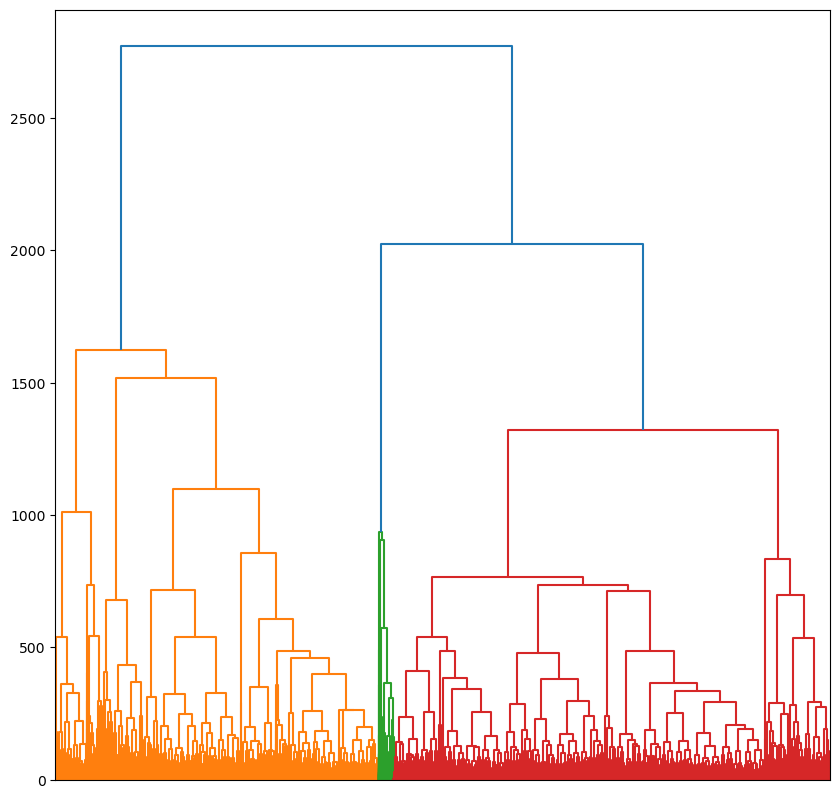

In [18]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix, ax=ax, no_labels=True)

In [19]:
final_cutoff = 750
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
final_clusters.value_counts()

11    174763
6      92432
10     73480
4      65084
13     43717
3      27304
1      21052
2      11360
9       9469
8        535
12        56
5          4
7          3
Name: count, dtype: int64

### Plotting

In [32]:
from core.cluster_validation import get_color
final_colors = pd.DataFrame(get_color(final_clusters.values), final_clusters.values).drop_duplicates()
final_colors.loc[-1] = [0,0,0]

In [87]:
# region_id = 69333 

# region_id = 99886 # bratislava

# region_id = 151676 # vilnius

# region_id = 8707 # mainz/frankfurt
# region_id = 5883 #  freiburg
# region_id = 38679 #munich
# region_id = 55763 # berlin

# region_id = 86873 # vienna

region_id = 107131 # krakow


# region_id= 66593 # usti

# region_id = 91011

# region_id = 8707

# region_id = 62954 # lindz

# region_id = 74378
# region_id = 93167
# region_id = 77205

In [89]:
# # etcs=False to read buildings, etcs=True for tessellation cells.


etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)

In [90]:
# etcs = morphotopes_to_etcs(69333, etcs=False, model_params=model_params)
# etcs2 = morphotopes_to_etcs(74378, etcs=False, model_params=model_params)

# etcs = pd.concat((etcs, etcs2), ignore_index=True)

In [92]:
## direct morphotope clustering
etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[x] if x in regional_ward_morphotopes_data.index else -1)

In [94]:
etcs['geometry'] = etcs.simplify(1).to_crs(epsg=4326).make_valid()
etcs = etcs[etcs['geometry'].geom_type == 'Polygon']

In [95]:
%%time
import lonboard
# plotting = tessellation[tessellation.index.isin(X_train.index)].copy()
layer = lonboard.SolidPolygonLayer.from_geopandas(etcs, opacity=.7)

CPU times: user 6.13 s, sys: 319 ms, total: 6.45 s
Wall time: 6.44 s


In [96]:
from sidecar import Sidecar
sc = Sidecar(title=f'Final Clusters')
m = lonboard.Map(layer, basemap_style=lonboard.basemap.CartoBasemap.DarkMatter)
with sc:
    display(m)

In [97]:
from core.cluster_validation import get_color
layer.get_fill_color = final_colors.loc[etcs.final].values.astype('uint8')

In [82]:
final_clusters.value_counts()

11    174763
6      92432
10     73480
4      65084
13     43717
3      27304
1      21052
2      11360
9       9469
8        535
12        56
5          4
7          3
Name: count, dtype: int64

## Save data

In [98]:
#potentially pick a new cutoff
final_cutoff = 200
clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
final_clusters = pd.Series(clusters, regional_ward_morphotopes_data.index)
final_clusters.value_counts()

99    21156
60    20065
97    18391
93    18110
57    17796
      ...  
45        3
61        3
11        2
8         1
46        1
Name: count, Length: 110, dtype: int64

In [99]:
cdata = grouped_data.groupby(final_clusters).median().fillna(0)
cdata

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbSqu,ssbERI,ssbElo,libNCo,ldbPWL,ltcBuA,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre
1,389.775612,94.278728,0.0,0.413456,0.358902,0.996464,0.456751,0.0,126.454408,0.894444,...,0.447964,0.943948,0.363889,48.216476,4.497810,4.497810,414.397558,350.350963,1.0,29202.268591
2,172.979938,58.750544,0.0,0.502542,0.384315,0.992234,0.585859,0.0,198.151437,0.600000,...,0.541369,0.738082,0.342873,66.538592,4.943476,4.943476,305.969256,289.735117,1.0,27760.053069
3,219.189543,67.110053,0.0,0.469869,0.353383,0.996027,0.529649,0.0,112.211980,0.800000,...,0.486252,0.915885,0.378657,41.749682,4.114390,4.114390,285.887493,254.066749,1.0,22403.023698
4,171.358009,58.717412,0.0,0.504157,0.290004,0.999439,0.570796,0.0,85.207061,0.857143,...,0.561674,0.962147,0.456233,31.256400,3.651711,3.651711,327.894679,355.550488,1.0,25178.278855
5,132.275873,49.850914,0.0,0.522749,0.278087,0.998933,0.602886,0.0,107.246249,0.666667,...,0.476896,0.899474,0.365204,38.776006,3.739775,3.739775,146.019319,145.578671,1.0,13644.267952
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,118.614305,47.702926,0.0,0.516041,0.916570,0.984577,0.638489,0.0,142.278105,0.600000,...,0.571173,0.726973,0.359988,46.232415,3.846917,3.846917,120.394837,123.528863,1.0,13285.761283
107,106.080259,45.704076,0.0,0.503791,0.804553,0.962605,0.639918,0.0,86.249212,0.750000,...,0.623504,0.827653,0.419443,28.889564,3.026651,3.026651,88.610366,95.751749,1.0,7997.640197
108,84.172947,39.892146,0.0,0.515850,1.874149,0.993128,0.639257,0.0,277.742634,0.428571,...,0.597542,0.481689,0.318741,69.422605,3.715541,3.715541,72.548363,81.146540,1.0,11793.210673
109,67.555383,35.490564,0.0,0.529719,1.328450,0.997165,0.655040,0.0,145.082231,0.500000,...,0.605087,0.635177,0.358224,43.009784,3.209901,3.209901,57.489866,65.374153,1.0,7259.397151


In [100]:
normalised_cdata = regional_ward_morphotopes_data.groupby(final_clusters).median().fillna(0)
normalised_cdata

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbSqu,ssbERI,ssbElo,libNCo,ldbPWL,ltcBuA,...,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre
1,6.255669,5.345239,-0.003262,-3.762805,-0.107379,0.290795,-2.802041,-0.08234,0.407508,0.675988,...,-1.790308,0.381238,-1.275208,0.897099,2.072793,2.072793,1.758428,1.002527,0.149898,1.550460
2,1.782032,1.903554,-0.003262,-1.247260,-0.083456,0.056274,-1.181185,-0.08234,1.085489,-1.178078,...,-0.950272,-1.211791,-1.513599,1.667060,2.637254,2.637254,1.167455,0.744195,0.149898,1.444593
3,2.735579,2.713356,-0.003262,-2.169857,-0.112575,0.266555,-1.886855,-0.08234,0.272829,0.081287,...,-1.445961,0.164082,-1.107694,0.625341,1.587169,1.587169,1.058002,0.592183,0.149898,1.051358
4,1.748563,1.900345,-0.003262,-1.201671,-0.172238,0.455709,-1.370286,-0.08234,0.017465,0.441106,...,-0.767658,0.522065,-0.227736,0.184376,1.001159,1.001159,1.286956,1.024687,0.149898,1.255077
5,0.942092,1.041430,-0.003262,-0.676668,-0.183457,0.427660,-0.967416,-0.08234,0.225872,-0.758289,...,-1.530102,0.037091,-1.260293,0.500377,1.112697,1.112697,0.295671,0.129828,0.149898,0.408417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,0.660182,0.833350,-0.003262,-0.866095,0.417594,-0.368178,-0.520452,-0.08234,0.557140,-1.178078,...,-0.682233,-1.297749,-1.319461,0.813722,1.248399,1.248399,0.156008,0.035856,0.149898,0.382101
107,0.401539,0.639717,-0.003262,-1.211998,0.312144,-1.586140,-0.502509,-0.08234,0.027320,-0.233554,...,-0.211588,-0.518672,-0.645051,0.084913,0.209484,0.209484,-0.017228,-0.082525,0.149898,-0.006076
108,-0.050525,0.076704,-0.003262,-0.871495,1.319033,0.105856,-0.510806,-0.08234,1.838118,-2.257534,...,-0.445077,-3.195808,-1.787337,1.788257,1.082003,1.082003,-0.104772,-0.144769,0.149898,0.272540
109,-0.393432,-0.349686,-0.003262,-0.479861,0.805327,0.329648,-0.312669,-0.08234,0.583656,-1.807760,...,-0.377224,-2.008086,-1.339478,0.678295,0.441581,0.441581,-0.186846,-0.211988,0.149898,-0.060267


In [101]:
# regional_clusters

In [102]:
final_clusters

4_0_1            4
4_0_10           6
4_0_100         88
4_0_101         88
4_0_102          3
                ..
152511_809_0    41
152511_8_0      28
152511_8_1      47
152511_8_2      60
152511_901_0    41
Length: 519259, dtype: int32

In [103]:
v = 'v10'

In [104]:
# regional_clusters.to_frame().to_parquet(f'/data/uscuni-ulce/processed_data/clusters/regional_clusters_{v}.pq')

In [105]:
final_clusters.to_frame().to_parquet(f'/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq')

In [106]:
cdata.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/cdata_{v}.pq')

In [107]:
normalised_cdata.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/normalised_cdata_{v}.pq')

In [108]:
regional_ward_morphotopes_data.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_input_data_{v}.pq')

In [109]:
np.save(f'/data/uscuni-ulce/processed_data/clusters/complete_linkage_{n_neighbors}_{v}.npy', linkage_matrix)

# Create mapping

In [111]:
## hierarchical cutoff

cutofffs = [200, 500, 750, 1000, 1500, 1750, 2000]

cluster_frame = []
for c in reversed(cutofffs):
    clusters = fcluster(linkage_matrix, t=c, criterion='distance')
    cluster_frame.append(pd.Series(clusters, regional_ward_morphotopes_data.index))
cluster_frame = pd.concat(cluster_frame, axis=1)
cluster_frame.columns = cluster_frame.columns + 1

cluster_frame.drop_duplicates().set_index(7).sort_index().to_parquet(f'/data/uscuni-ulce/processed_data/clusters/cluster_mapping_{v}.pq')

## Assign clusters to ETCs in all regions

In [113]:
v = 'v10'
merged_clusters = pd.read_parquet(f'/data/uscuni-ulce/processed_data/clusters/final_clusters_{v}.pq')[0]
merged_clusters.nunique()

110

In [115]:
%%time

# morphotope code
for region_id, _ in region_hulls.iterrows():
    print(region_id)
    etcs = morphotopes_to_etcs(region_id, etcs=False, model_params=model_params)
    etcs['final'] = etcs['morph'].map(lambda x: final_clusters.loc[x] if x in regional_ward_morphotopes_data.index else -1)
    etcs.to_parquet(f'/data/uscuni-ulce/processed_data/clusters/clusters_{region_id}_{v}.pq')

4
10
132
134
286
313
400
523
765
801
832
913
960
1124
1154
1387
1478
1515
1605
1718
1736
1782
1970
1981
2096
2322
2350
2478
2514
2625
2728
2975
3039
3109
3150
3221
3250
3526
3610
3612
3701
3705
3752
3759
3981
4070
4214
4215
4235
4284
4356
4382
4723
4805
5096
5191
5246
5310
5408
5427
5662
5671
5766
5883
6254
6529
6560
6576
6741
6749
6811
6873
6996
7068
7094
7280
7485
7528
7534
7681
7688
7712
7727
7805
7914
7937
7963
8046
8216
8238
8256
8265
8345
8374
8396
8592
8707
8731
8757
8759
8813
9016
9064
9074
9150
9169
9194
9284
9824
9924
9954
9972
10019
10086
10095
10124
10179
10222
10263
10277
10455
10510
10511
10563
10579
10602
10666
10794
10847
10908
10926
10970
11002
11019
11057
11141
11210
11256
11261
11305
11309
11311
11318
11367
11444
11455
11471
11667
11678
11735
11757
11799
11877
11905
12027
12084
12100
12115
12154
12191
12381
12440
12483
12552
12667
12707
12755
12756
12844
12919
12965
13076
13137
13172
13191
13196
13229
13301
13395
13442
13482
13506
13553
13555
13614
13616
13655
13677


## Morphotope Distances

In [36]:
## suburb housing, village centre, vinohrady grid, commie block
sel_morphs = [ '69333_849_38', '69333_849_171', '69333_849_79', '69333_849_403', '69333_849_486', '69333_849_116']
sel_morphs_categories = ['single family', 'village centre', 'grid blocks', 'modernist housing', 'industrial area', 'medieval street block']
query_size = 4

In [38]:

# load data
sel_morphs_indices = [regional_ward_morphotopes_data.index.get_loc(m) for m in sel_morphs]
nn_morphs_flatten = regional_ward_morphotopes_data.iloc[nns[sel_morphs_indices, :query_size].flatten()].index
nn_morphs = nn_morphs_flatten.values.reshape(len(sel_morphs), query_size)

# load the etcs for the specific nearest neigbhours morphs
regions = nn_morphs_flatten.str.split('_').str[0].values
nn_etcs = []
for region in np.unique(regions):
    region_etcs = morphotopes_to_etcs(region, etcs=False, model_params=model_params)
    region_etcs = region_etcs[region_etcs.morph.isin(nn_morphs_flatten)]
    nn_etcs.append(region_etcs)

nn_etcs = pd.concat(nn_etcs)

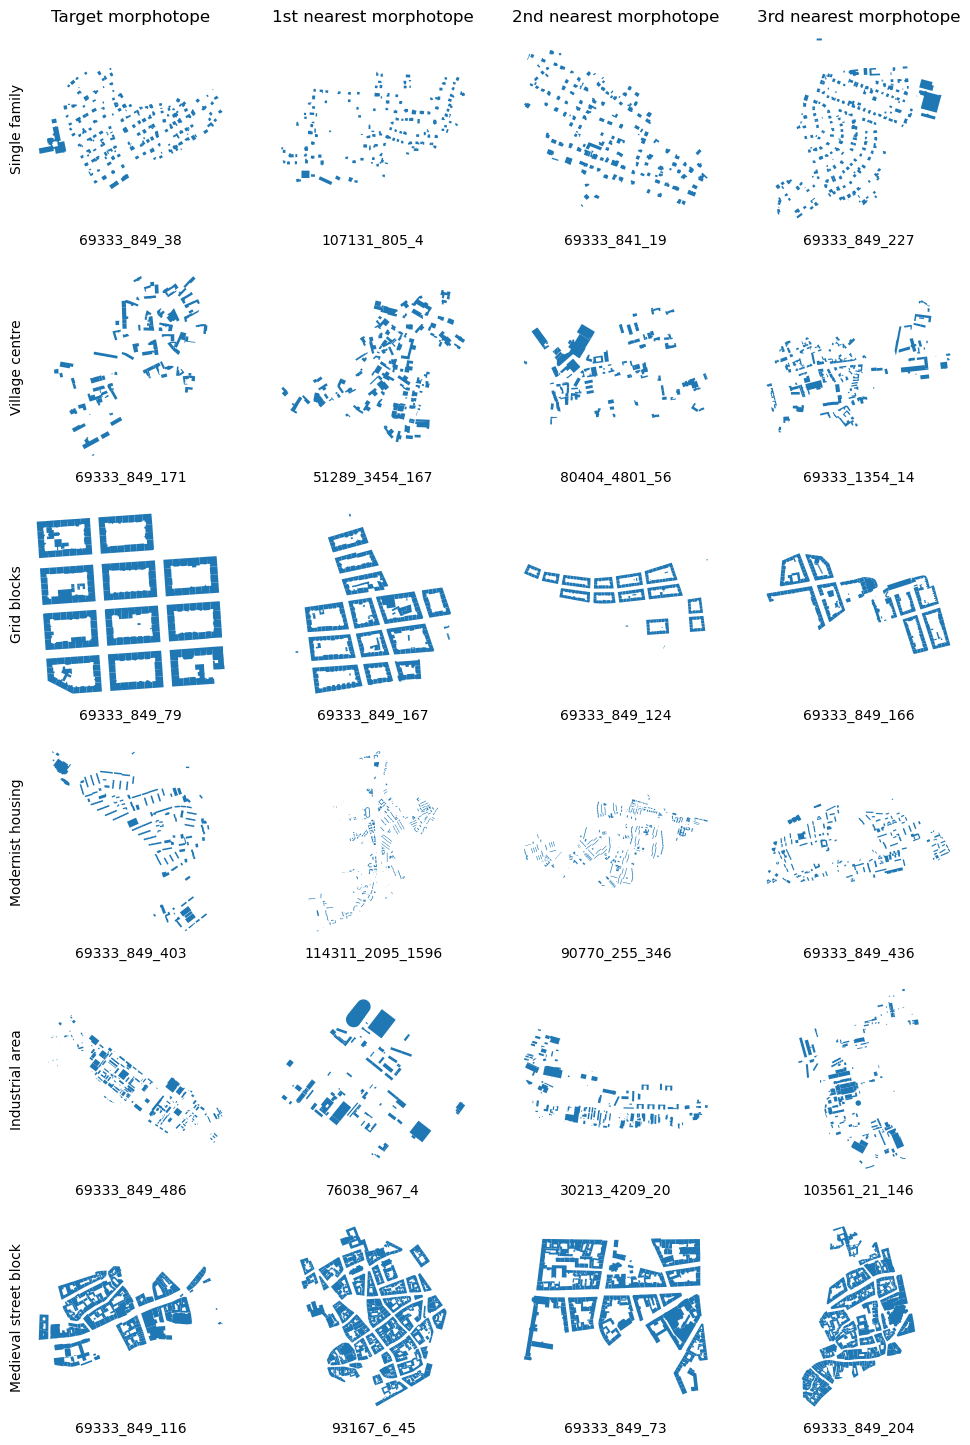

In [39]:
# plot results
import matplotlib.pyplot as plt
from core.utils import make_ordinal
ax_side = 3
fig, axes = plt.subplots(nrows=nn_morphs.shape[0], ncols=query_size, figsize=(query_size * ax_side, len(sel_morphs) * ax_side))

for i, ax_row in enumerate(axes):
    for j, ax in enumerate(ax_row):
        morph = nn_morphs[i,j]
        morph_buildings = nn_etcs[nn_etcs.morph == morph]
        morph_buildings.plot(ax=ax)
        ax.axis('equal')
        ax.set_yticks([])
        ax.set_xticks([])
        ax.set_frame_on(False)
    
        if j == 0:
            ax.set_ylabel(sel_morphs_categories[i].capitalize())

        if i == 0:
            if j == 0:
                ax.set_title('Target morphotope')
            else:
                ax.set_title(f'{make_ordinal(j)} nearest morphotope')
            # ax.xaxis.set_label_position('top')

        ax.set_xlabel(f'{morph}')

In [41]:
nn_etcs[nn_etcs.morph == '93167_6_45'].explore()

In [65]:
from sklearn.cluster import KMeans, MiniBatchKMeans, BisectingKMeans
quick = True

In [66]:
%%time

## recursive kmeans up-to level...
recursion_level = 4

orig_data = regional_ward_morphotopes_data.values
n_samples = orig_data.shape[0]
labels_ = np.zeros((n_samples, recursion_level + 1), dtype=int)

# for each recursion level
for rl in range(1, recursion_level + 1):
    
    # for each cluster in the previous level
    for cluster_num in np.unique(labels_[:, rl-1]):
        print(rl, cluster_num)

        # get and normalise subcluster data
        indices = np.where(labels_[:, rl-1] == cluster_num)[0]
        if indices.shape[0] == 1:
            labels_[indices, rl] = (cluster_num * 2)
            continue
            
        X = orig_data[indices]
        vals = X
        
        # scalar = StandardScaler()
        # vals = scalar.fit_transform(X)
        # vals = np.nan_to_num(vals, 0)
        
        # fit model and assign labels
        if quick:
            kmeans = KMeans(n_clusters=2, random_state=123, n_init=100)
        else:
            kmeans = KMeans(n_clusters=2, random_state=123, n_init=500)
        kmeans.fit(vals)
        labels_[indices, rl] = kmeans.labels_ + (cluster_num * 2)

1 0
2 0
2 1
3 0
3 1
3 2
3 3
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
CPU times: user 45min 53s, sys: 6.41 s, total: 45min 59s
Wall time: 2min 45s


In [67]:
class DivisiveClustering:
    def __init__(self):
        self.labels_ = None
        self.linkage_matrix = None
        self.current_id = 0

    def fit(self, X):
        n_samples = X.shape[0]
        self.labels_ = np.zeros(n_samples, dtype=int)
        self.linkage_matrix = []
        self.current_id = n_samples
        
        # Start with all points in one cluster, initial recursion_level is 1
        self._recursive_split(X, np.arange(n_samples), 1)
        
        self.linkage_matrix = np.array(self.linkage_matrix)
        return self

    def _recursive_split(self, X, indices, recursion_level):
        if len(indices) <= 1:
            return indices[0], 1
        
        kmeans = KMeans(n_clusters=2, random_state=123, n_init=500)
        kmeans.fit(X[indices])
        
        mask0 = kmeans.labels_ == 0
        mask1 = kmeans.labels_ == 1
        indices0 = indices[mask0]
        indices1 = indices[mask1]
        
        id0, size0 = self._recursive_split(X, indices0, recursion_level + 1)
        id1, size1 = self._recursive_split(X, indices1, recursion_level + 1)
        
        # Use 1/recursion_level as distance
        distance = 1.0 / recursion_level
        
        self.linkage_matrix.append([float(min(id0, id1)), float(max(id0, id1)), 
                                  float(distance), float(size0 + size1)])
        
        current_cluster = self.current_id
        self.current_id += 1
        return current_cluster, size0 + size1

In [68]:
# cluster_data = regional_ward_morphotopes_data[(regional_ward_morphotopes_data.index.str.startswith('69333') | 
#                                                regional_ward_morphotopes_data.index.str.startswith('91011') | 
#                                                regional_ward_morphotopes_data.index.str.startswith('93167'))]

cluster_data = regional_ward_morphotopes_data.copy()

In [36]:
# %%time

# clusterer = BisectingKMeans(n_clusters=16, n_init=100)
# clusterer.fit(cluster_data.values)

In [43]:
# %%time
# clusterer = DivisiveClustering()
# start = np.datetime64('now')
# clusterer.fit(cluster_data.values)
# end = np.datetime64('now')

In [44]:
# np.save('/data/uscuni-ulce/taxonomies/kmeans_linkage_smooth_morphotopes.npy', clusterer.linkage_matrix)

In [45]:
# linkage_matrix = np.load('/data/uscuni-ulce/taxonomies/kmeans_linkage_smooth_morphotopes.npy')

# # linkage_matrix = clusterer.linkage_matrix

In [46]:
# ## final dendrogram
# import matplotlib.pyplot as plt
# from scipy.cluster.hierarchy import dendrogram
# fig,ax = plt.subplots(figsize=(10,10))
# _ = dendrogram(linkage_matrix, ax=ax, no_labels=True)

In [47]:
# final_cutoff = 1/7 -0.00001
# clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
# final_clusters = pd.Series(clusters, cluster_data.index)
# final_clusters.value_counts()

In [48]:
# final_clusters.value_counts().value_counts()

In [8]:
regional_cutoff = 2.5

In [9]:
regional_clusters = get_all_clusters(cutoff=regional_cutoff)

processing 4


ValueError: Length of values (57562) does not match length of index (57560)

In [7]:
np.unique(regional_clusters).shape

(66494,)

In [8]:
# why are these different  - 

In [9]:
# %%time
morphotopes_data = read_morphotopes_data(model_params)
morphotopes_data = morphotopes_data.loc[regional_clusters.index]
morphotopes_data = morphotopes_data.iloc[:, :-1]

In [10]:
component_data = morphotopes_data.drop(columns=morphotope_stat_columns, level=1)
component_data = component_data.drop(columns=to_drop, level=0)
component_data.columns = component_data.columns.get_level_values(0)
# component_data['sdbCoA'] = morphotopes_data.loc[:, 'sdbCoA']['mean']

In [11]:
%%time
morph_chars_data = read_morphotopes_chars()
morph_chars_data = morph_chars_data[['limLPS']]


merged_data = pd.merge(component_data, morph_chars_data, how='inner', left_index=True, right_index=True)
pd.testing.assert_index_equal(merged_data.index, component_data.index)
component_data = merged_data

CPU times: user 1.01 s, sys: 264 ms, total: 1.27 s
Wall time: 923 ms


In [12]:
component_data.loc[['93167_1802_0' , '91011_895_0']]

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,...,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS
93167_1802_0,125.845496,47.872983,0.0,0.537625,6.0,0.372616,0.974698,0.663602,0.0,0.0,...,50.821931,0.681935,0.963679,0.540910,17.738801,2.728918,2.728918,77.438724,88.052753,1.0
91011_895_0,146.647818,54.164526,0.0,0.515053,4.0,0.578495,0.998408,0.629821,0.0,0.0,...,55.410041,0.621665,1.001599,0.523915,20.582737,2.793874,2.793874,147.467742,150.848301,1.0


In [13]:
grouped_data = component_data.groupby(regional_clusters).agg('median').fillna(0)
grouped_data = grouped_data.drop(grouped_data.columns[grouped_data.std() == 0], axis=1)

In [14]:
grouped_data.loc[['93167_159' , '91011_76']]

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,...,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS
93167_159,110.909878,45.151081,0.0,0.550615,6.0,0.630241,0.970515,0.738956,0.0,0.0,...,49.125985,0.728091,0.965074,0.548232,17.640081,2.641372,2.641372,57.185507,58.356939,1.0
91011_76,136.005849,51.920073,0.0,0.509174,4.0,0.821341,0.995693,0.663834,0.0,0.0,...,55.618098,0.642422,0.996976,0.498945,20.342171,2.776168,2.776168,100.048444,102.965102,1.0


<Axes: ylabel='Frequency'>

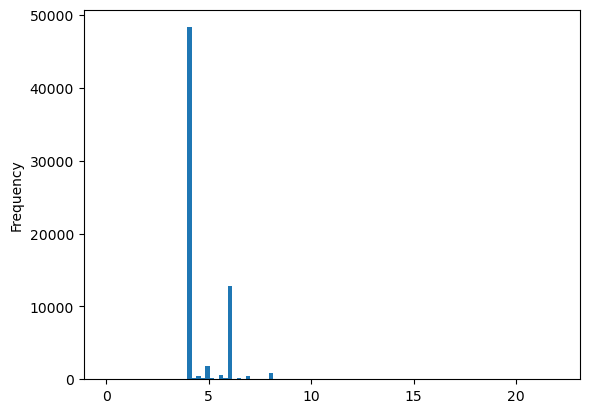

In [15]:
grouped_data.ssbCor.plot.hist(bins=100)

In [233]:
# %%time

# ## bisecting kmeans up-to level...
# recursion_level = 16

# orig_data = regional_ward_morphotopes_data.values
# n_samples = orig_data.shape[0]
# labels_ = np.zeros((n_samples, recursion_level + 1), dtype=int)

# from scipy.spatial.distance import cdist

# # for each recursion level
# for rl in range(1, recursion_level + 1):

#     # pick the next cluster to split
#     max_interia = 0
#     max_indices = []
#     max_cluster = 0
#     centres = regional_ward_morphotopes_data.groupby(labels_[:, rl-1]).mean()
    
#     for cluster_num, centre in centres.iterrows():
    
#         indices = np.where(labels_[:, rl-1] == cluster_num)[0]
#         if indices.shape[0] < 5000:
#             continue
        
#         cluster_inertia = cdist(centre.values[np.newaxis, :], orig_data[indices]).sum()
        
#         if cluster_inertia > max_interia:
#             max_cluster = cluster_num
#             max_indices = indices
#             max_interia = cluster_inertia
            
#     vals = orig_data[max_indices]

#     # fit model and assign labels
#     if quick:
#         kmeans = KMeans(n_clusters=2, random_state=123)
#     else:
#         kmeans = KMeans(n_clusters=2, random_state=123, n_init=500)
#     kmeans.fit(vals)

#     #assign clusters
#     labels_[:, rl] = labels_[:, rl - 1]
#     labels_[max_indices, rl] = kmeans.labels_ + (max(labels_[:, rl - 1])  * 2)

In [93]:
%%time
clusterer = KMeans(n_clusters=256, random_state=123)
clusterer.fit(cluster_data.values)

CPU times: user 4min 6s, sys: 197 ms, total: 4min 6s
Wall time: 22.6 s


KMeans(n_clusters=256, random_state=123)

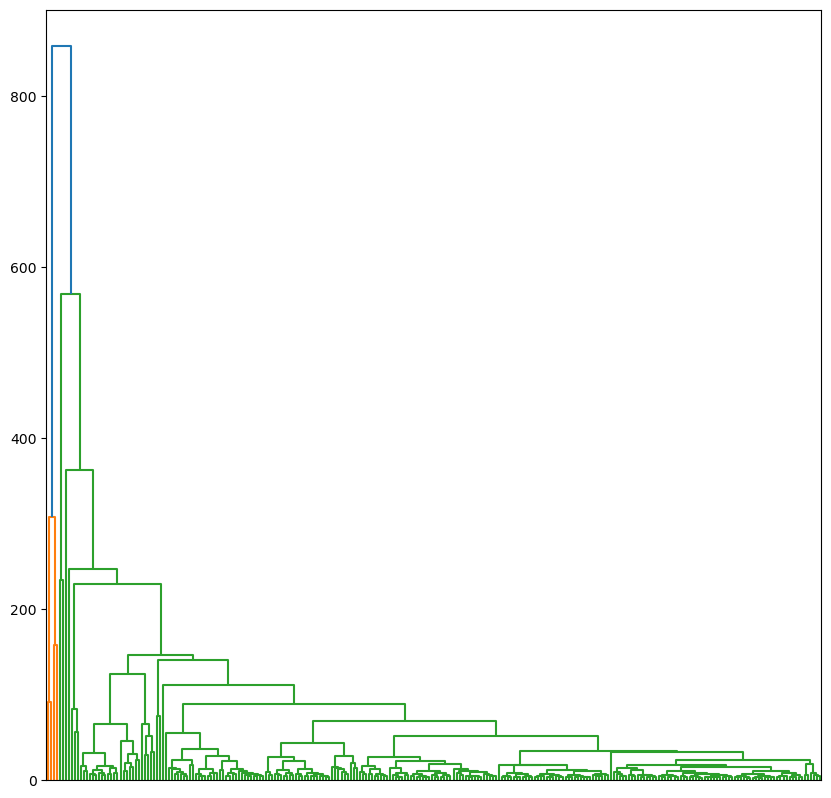

In [94]:
from scipy.cluster.hierarchy import dendrogram, fcluster, linkage
from scipy.spatial.distance import pdist
linkage_matrix = linkage(pdist(clusterer.cluster_centers_), method='ward')
fig,ax = plt.subplots(figsize=(10,10))
_ = dendrogram(linkage_matrix, ax=ax, no_labels=True)

In [114]:
final_cutoff = 25
centre_clusters = fcluster(linkage_matrix, t=final_cutoff, criterion='distance')
cluster_map = pd.Series(centre_clusters, index=np.arange(clusterer.cluster_centers_.shape[0])).to_dict()
final_clusters = pd.Series(clusterer.labels_, index=cluster_data.index).map(cluster_map)
final_clusters.value_counts()

33    221457
32     99213
31     73916
27     30611
24     18075
30     10283
23      8748
11      6810
22      4370
28      2722
26      1222
12       698
10       588
29       463
13       177
15        93
34        83
17        65
35        51
25        38
14        31
18        20
7         17
16        15
19        11
21         8
8          6
9          6
4          4
5          3
20         3
36         2
37         1
3          1
2          1
1          1
6          1
Name: count, dtype: int64

In [96]:
final_clusters = pd.Series(pd.Series(labels_[:, -1]).factorize()[0], cluster_data.index)


In [65]:
import umap
from sklearn.decomposition import PCA
from sklearn.preprocessing import PowerTransformer

In [74]:
cluster_data.head().style

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,ldbPWL,ltcBuA,mtbAli,mtbNDi,ltbIBD,stbSAl,sdsLen,sssLin,ldsMSL,ldsRea,ldsAre,sisBpM,sdsSPW,sdsSPO,sdsSWD,lcdMes,linP3W,linP4W,linPDE,lcnClo,lddNDe,linWID,ldsCDL,xcnSCl,mtdMDi,sddAre,midRea,midAre,sdcLAL,sdcAre,sscCCo,sscERI,mtcWNe,mdcAre,ltcWRB,sicCAR,sdsAre,mibCou,mibAre,mibLen,mibElo,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre,limPer
4_0_1,1.005706,1.450018,-0.003394,-1.994497,-0.423981,0.494222,-2.092633,-0.818089,-0.085782,0.184315,0.129066,-1.382250,1.382419,1.456023,-0.349276,0.046795,0.277197,0.494989,0.552800,0.857533,0.351026,1.820411,1.721926,-0.401699,-0.776610,-0.687206,1.263457,-0.120317,-0.565306,-0.604902,-0.654810,-0.206805,-0.518426,0.068678,0.843899,-0.260248,0.141830,2.401174,1.997463,-0.110852,-0.281298,-1.743540,2.848123,-1.174980,-1.064860,1.027094,-0.168677,0.114150,0.098236,-1.304019,0.490412,-0.586970,0.459331,1.482120,1.482120,3.692437,4.893396,0.152550,3.796853,2.680532
4_0_10,1.018026,1.214277,-0.003394,-0.822800,-0.343074,0.496862,-1.601863,0.132670,-0.085782,0.159191,-0.185193,-0.678473,0.255692,0.546997,-0.685623,0.049830,0.380240,-0.084613,-0.123390,0.316823,-0.392956,1.509512,0.537654,-0.233488,-0.423584,-0.041496,0.771276,-0.402871,-0.564642,-0.928985,-1.068118,-0.126581,0.435123,-0.019079,-0.031924,0.257549,0.404210,0.528830,0.323731,0.226769,0.247543,-0.886061,0.723572,-0.874827,0.034226,-0.107958,-0.168677,0.123463,0.080180,-0.161294,0.424455,0.069799,0.452954,1.182741,1.182741,1.191267,1.114545,0.152550,0.863756,0.617428
4_0_100,-0.114880,-0.136634,-0.003394,-0.496307,-0.366147,-0.830455,0.699141,0.551471,-0.085782,-0.119821,-0.409664,-1.369856,-0.396909,-0.643566,-0.747892,-0.385017,0.376225,-0.697086,-0.062265,-0.579029,0.106307,-0.296116,-0.868991,-1.068994,-0.387136,-0.845533,0.450299,0.516627,-0.555948,1.268757,1.452234,-0.321553,-0.518426,-0.485916,-0.438291,-0.184101,-0.508430,-0.468436,-0.471831,-0.781069,-1.306457,0.452839,-0.621672,0.773666,0.215210,-0.403759,-0.168677,-0.117091,-0.123383,-0.522777,-0.532577,-0.533208,-0.098077,-0.044941,-0.044941,-0.206150,-0.228880,0.152550,-0.322550,-0.250401
4_0_101,-0.436067,-0.474261,-0.003394,0.321205,-0.299041,0.188260,0.716970,1.251627,-0.085782,0.041747,-1.307548,-0.868225,-0.824644,-0.666478,-0.755852,-0.460593,0.385156,-0.494661,1.863155,-0.299334,0.340283,-0.489533,-1.029491,-0.631783,0.551265,-0.520955,1.030696,-0.309977,-0.558852,-0.158127,-0.085598,-0.227983,-0.518426,-0.429127,-0.367381,1.689103,-0.258118,-0.694181,-0.645703,-1.362151,-0.142712,0.833145,-0.687113,0.606004,0.786850,-0.407964,0.232861,-0.069085,-0.003734,-0.639472,-1.099884,-1.166654,0.154446,0.241622,0.241622,-0.313727,-0.333506,0.152550,-0.239966,0.058437
4_0_102,2.689112,2.784244,-0.003394,-3.203263,-0.373397,0.257855,-3.049562,-0.929062,-0.085782,0.299250,0.129066,0.559894,0.561513,-0.238279,-0.411408,-0.320859,0.394844,-0.492858,0.782016,-0.322810,-0.408811,1.139258,0.117512,-0.760085,0.549910,-0.586763,1.330091,-0.591241,-0.558682,0.294020,0.599255,-0.480625,-0.518426,-0.277818,-0.316225,0.044338,-0.343054,0.695898,0.727629,1.144921,1.000469,-0.670950,0.400801,-0.212474,0.214313,-0.324476,-0.369446,0.135412,0.182824,-2.149063,0.430432,-1.342870,0.761624,1.544898,1.544898,0.695982,0.236083,0.152550,0.592133,0.738707


In [130]:
new_data = grouped_data.copy()
description = new_data.describe()


In [132]:
for col in description:
    if description.loc['25%', col] == description.loc['min', col]:
        print(col)

sdbCoA
mtbSWR
mibCou


In [365]:
## the range of everything is more than 10 standard deviations...
cols = []
for col in description:
    num_stds = (description[col]['max'] - description[col]['min']) / description[col]['std']
    print(col, num_stds)

In [405]:
%%time
res = PowerTransformer().fit_transform(new_data)
res = pd.DataFrame(np.nan_to_num(res), index=new_data.index, columns=new_data.columns)

CPU times: user 11.2 s, sys: 109 ms, total: 11.3 s
Wall time: 11.3 s


In [412]:
res

,sdbAre,sdbPer,sdbCoA,ssbCCo,ssbCor,ssbSqu,ssbERI,ssbElo,mtbSWR,libNCo,...,mibERI,mibCCo,mibLAL,mibFR,mibSCo,micBAD,midBAD,limLPS,limAre,limPer
4_0_0,-3.150230,-2.976369,-0.004065,-2.039142,-0.585278,-0.170075,0.516426,0.862133,1.176457,-0.13121,...,1.477178,2.272532,-3.825649,-3.766755,-3.766755,-3.954613,-3.167489,0.152457,-3.863953,-3.884145
4_0_1,1.221571,1.449923,-0.004065,-1.909210,-0.585278,-1.872097,0.551195,-1.853056,-0.874001,-0.13121,...,0.473889,-0.745502,1.160718,1.571439,1.571439,3.155553,2.793596,0.152457,2.348169,2.033774
4_0_10,1.230866,1.274972,-0.004065,-0.854775,-0.585278,-1.107684,0.555268,-1.500675,0.399714,-0.13121,...,0.338226,-0.085075,1.154324,1.343111,1.343111,2.161128,1.990522,0.152457,1.561423,1.038284
4_0_100,0.123722,0.024506,-0.004065,-0.540139,1.328062,-1.303824,-1.135756,0.679008,0.777464,-0.13121,...,-1.031091,-0.696699,0.349256,0.127462,0.127462,-0.250328,-0.322387,0.152457,-0.326070,0.032559
4_0_101,-0.341644,-0.380656,-0.004065,0.289635,-0.585278,-0.773496,0.100164,0.699770,1.251720,-0.13121,...,-1.472672,-1.218524,0.793550,0.460843,0.460843,-0.990504,-1.357187,0.152457,0.044402,0.484400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152511_77_0,0.590610,0.468123,-0.004065,0.512473,-0.585278,-0.492333,0.562032,0.379796,-1.075718,-0.13121,...,1.381904,1.196641,-1.023222,-0.531992,-0.531992,-0.051722,-0.315298,0.152457,-0.778614,-0.936555
152511_77_1,-0.035260,-0.090484,-0.004065,0.771939,-0.585278,-0.057113,0.563999,0.513368,-1.075718,-0.13121,...,1.389935,1.374623,-1.353256,-1.125084,-1.125084,-0.203872,0.263422,0.152457,-0.749932,-1.041658
152511_8_0,0.611596,0.648530,-0.004065,-0.123379,-0.585278,-0.200418,0.563704,-0.354402,-1.075718,-0.13121,...,1.376163,0.909983,-0.740389,-0.593865,-0.593865,0.305061,0.600523,0.152457,-0.516041,-0.613993
152511_8_1,0.810622,0.796681,-0.004065,0.162704,1.328062,-0.151467,-2.013742,0.710523,-1.075718,-0.13121,...,0.631960,1.076713,-0.876648,-0.495724,-0.495724,0.766229,0.463648,0.152457,-0.082756,-0.371627


In [377]:
sel_cols = cols

In [378]:
# sel_cols = ['mibAre','mibLen','mibElo','mibERI','mibCCo','mibLAL','mibFR','mibSCo','micBAD','midBAD', 'limAre', 'limPer', 'mtbSWR', 'lcdMes', 'sdsSPW', 'xcnSCl', 'sicCAR']

In [75]:
res = cluster_data

In [76]:
reducer = PCA(n_components=2)
pca_embedding = reducer.fit_transform(res)

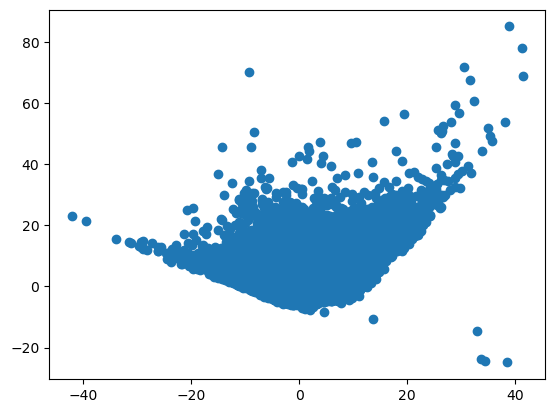

In [77]:
fig, ax = plt.subplots()
ax.scatter(pca_embedding[:, 0], pca_embedding[:, 1])

In [78]:
%%time
reducer = umap.UMAP(n_neighbors=15, verbose=True)
embedding = reducer.fit_transform(res.loc[:, ~(res.columns.str[2] == 'c')])

/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


UMAP(min_dist=0, n_neighbors=5, verbose=True)
Sat May  3 20:23:32 2025 Construct fuzzy simplicial set
Sat May  3 20:23:32 2025 Finding Nearest Neighbors
Sat May  3 20:23:32 2025 Building RP forest with 40 trees
Sat May  3 20:23:36 2025 NN descent for 19 iterations
	 1  /  19
	 2  /  19
	 3  /  19
	 4  /  19
	Stopping threshold met -- exiting after 4 iterations
Sat May  3 20:23:43 2025 Finished Nearest Neighbor Search
Sat May  3 20:23:45 2025 Construct embedding


/home/krasen/urban_taxonomy/.pixi/envs/default/lib/python3.12/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Sat May  3 20:25:44 2025 Finished embedding
CPU times: user 39min, sys: 23.6 s, total: 39min 24s
Wall time: 2min 12s


In [79]:
embedding = pd.DataFrame(embedding, index=cluster_data.index)
embedding.to_parquet('../data/morphotope_embedding_no_isolates.pq')

<Axes: >

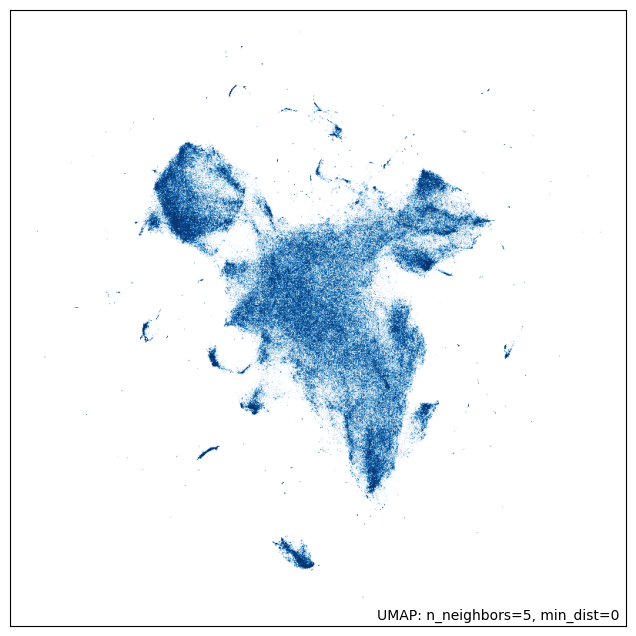

In [99]:
import umap.plot
umap.plot.points(reducer, )